# 03. Text Generation - GPT가 텍스트를 생성하는 방법

이 노트북에서는 **GPT가 어떻게 텍스트를 생성하는지** 단계별로 이해합니다.

## 핵심 개념
- Autoregressive generation (자기회귀 생성)
- Temperature sampling
- Top-k, Top-p sampling
- Beam search

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)

## 1. Autoregressive Generation 이해

**핵심**: 한 번에 한 토큰씩 생성, 이전 출력이 다음 입력

In [5]:
# 간단한 vocabulary
vocab = ['<PAD>', 'The', 'cat', 'sat', 'on', 'the', 'mat', '.', 'dog', 'ran']
vocab_size = len(vocab)
print("vocab_size: ", vocab_size)
stoi = {ch: i for i, ch in enumerate(vocab)}  # string to int
itos = {i: ch for i, ch in enumerate(vocab)}  # int to string

print("Vocabulary:")
for i, word in enumerate(vocab):
    print(f"  {i}: {word}")

# 시작 토큰
context = [stoi['The']]  # "The"로 시작
print(f"\n시작 context: {[itos[i] for i in context]}")

vocab_size:  10
Vocabulary:
  0: <PAD>
  1: The
  2: cat
  3: sat
  4: on
  5: the
  6: mat
  7: .
  8: dog
  9: ran

시작 context: ['The']


## 2. 다음 토큰 예측 과정

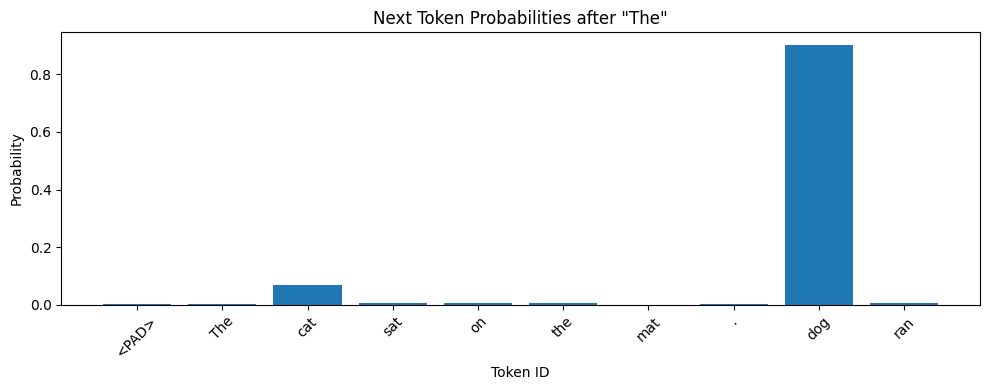


Top 3 predictions:
  dog        0.901
  cat        0.068
  ran        0.007


In [23]:
# 가상의 모델 출력 (logits)
# 실제로는 GPT가 예측하지만, 여기서는 수동으로 설정
def mock_gpt_prediction(context):
    """주어진 context에서 다음 토큰 확률 반환 (가상)"""
    # 실제로는 model(context)로 계산
    logits = torch.randn(vocab_size)
    
    # 문법적으로 가능한 패턴 강조 (예시)
    if context[-1] == stoi['The']:
        logits[stoi['cat']] += 3
        logits[stoi['dog']] += 2
    elif context[-1] == stoi['cat']:
        logits[stoi['sat']] += 3
        logits[stoi['ran']] += 1
    elif context[-1] == stoi['sat']:
        logits[stoi['on']] += 4

    return logits

# 예측
logits = mock_gpt_prediction(context)
probs = F.softmax(logits, dim=-1)

# 확률 시각화
plt.figure(figsize=(10, 4))
plt.bar(range(vocab_size), probs.numpy())
plt.xlabel('Token ID')
plt.ylabel('Probability')
plt.title('Next Token Probabilities after "The"')
plt.xticks(range(vocab_size), vocab, rotation=45)
plt.tight_layout()
plt.show()

# Top 3 확률
top_probs, top_indices = torch.topk(probs, 3)
print("\nTop 3 predictions:")
for prob, idx in zip(top_probs, top_indices):
    print(f"  {itos[idx.item()]:10} {prob:.3f}")

In [19]:
def itos_explanation():
    print("itos[idx.item()]의 의미:")
    print("itos: integer to string (숫자 → 문자열 변환)")
    print("idx: 토큰의 인덱스")
    print("idx.item(): 텐서를 스칼라 값으로 변환")
    
    # 예시
    itos = {0: 'The', 1: 'cat', 2: 'dog', 3: 'sat', 4: 'ran', 5: 'on'}
    idx = torch.tensor(1)
    
    print(f"idx: {idx}")
    print(f"idx.item(): {idx.item()}")
    print(f"itos[idx.item()]: {itos[idx.item()]}")

itos_explanation()

itos[idx.item()]의 의미:
itos: integer to string (숫자 → 문자열 변환)
idx: 토큰의 인덱스
idx.item(): 텐서를 스칼라 값으로 변환
idx: 1
idx.item(): 1
itos[idx.item()]: cat


## 3. Greedy Decoding vs Sampling

**Greedy**: 항상 가장 확률 높은 토큰 선택
**Sampling**: 확률 분포에서 랜덤 샘플링

In [25]:
def generate_greedy(start_context, num_tokens=5):
    """Greedy decoding: 항상 최고 확률 선택"""
    context = start_context.copy()
    
    for _ in range(num_tokens):
        logits = mock_gpt_prediction(context)
        probs = F.softmax(logits, dim=-1)
        next_token = torch.argmax(probs).item()
        context.append(next_token)
    
    return context

def generate_sampling(start_context, num_tokens=5):
    """Random sampling: 확률에 따라 샘플링"""
    context = start_context.copy()
    
    for _ in range(num_tokens):
        logits = mock_gpt_prediction(context)
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1).item()
        context.append(next_token)
    
    return context

# 비교
print("Greedy Decoding (결정적):")
for i in range(3):
    result = generate_greedy([stoi['The']], 4)
    print(f"  {i+1}: {' '.join([itos[t] for t in result])}")

print("\nRandom Sampling (다양함):")
for i in range(3):
    result = generate_sampling([stoi['The']], 4)
    print(f"  {i+1}: {' '.join([itos[t] for t in result])}")

Greedy Decoding (결정적):
  1: The cat sat on dog
  2: The cat sat on dog
  3: The cat sat on <PAD>

Random Sampling (다양함):
  1: The cat sat . dog
  2: The cat sat on cat
  3: The dog The cat sat


## 4. Temperature Sampling

Temperature로 확률 분포의 "sharpness" 조절:
- **Low temperature (< 1.0)**: 더 확실한 선택
- **High temperature (> 1.0)**: 더 다양한 선택

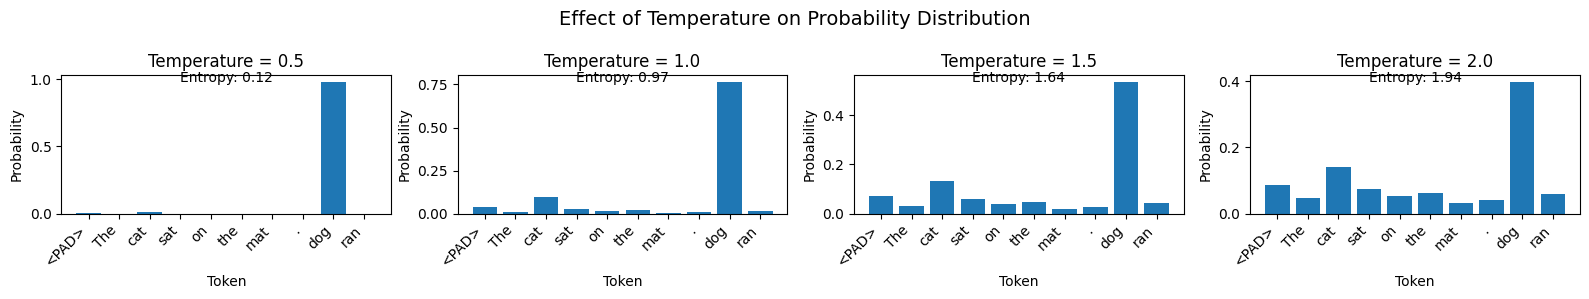

Temperature 효과:
- 낮은 T (0.5): 확률 차이 증폭, 보수적 선택
- 높은 T (2.0): 확률 평준화, 창의적 선택


In [27]:
def apply_temperature(logits, temperature):
    """Temperature를 적용한 logits"""
    return logits / temperature

# 다양한 temperature 비교
logits = mock_gpt_prediction([stoi['The']])
temperatures = [0.5, 1.0, 1.5, 2.0]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for i, temp in enumerate(temperatures):
    scaled_logits = apply_temperature(logits, temp)
    probs = F.softmax(scaled_logits, dim=-1)
    
    axes[i].bar(range(vocab_size), probs.numpy())
    axes[i].set_title(f'Temperature = {temp}')
    axes[i].set_xlabel('Token')
    axes[i].set_ylabel('Probability')
    axes[i].set_xticks(range(vocab_size))
    axes[i].set_xticklabels(vocab, rotation=45, ha='right')
    
    # Entropy 계산 (다양성 척도)
    entropy = -(probs * torch.log(probs + 1e-8)).sum().item()
    axes[i].text(0.5, 0.95, f'Entropy: {entropy:.2f}', 
                transform=axes[i].transAxes, ha='center')

plt.suptitle('Effect of Temperature on Probability Distribution', fontsize=14)
plt.tight_layout()
plt.show()

print("Temperature 효과:")
print("- 낮은 T (0.5): 확률 차이 증폭, 보수적 선택")
print("- 높은 T (2.0): 확률 평준화, 창의적 선택")

## 5. Top-k Sampling

상위 k개 토큰 중에서만 샘플링

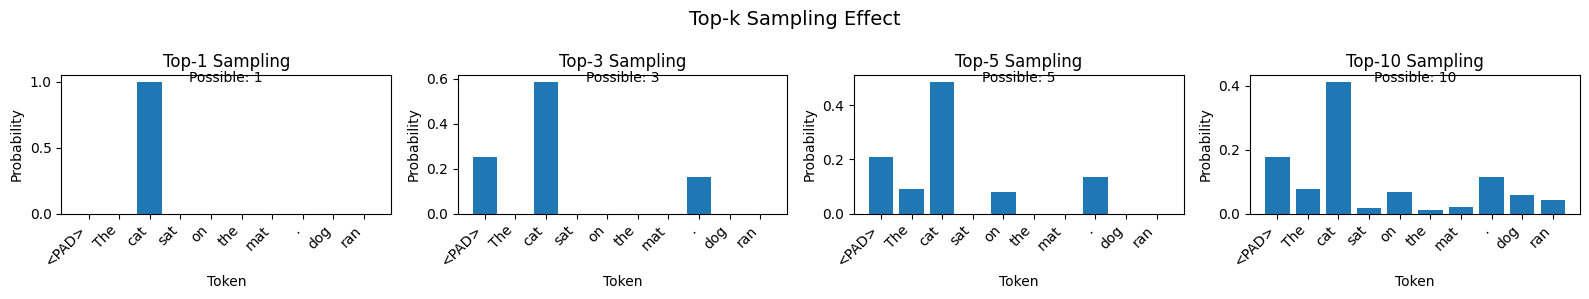

Top-k 효과:
- k=1: Greedy decoding과 동일
- k=3: 상위 3개 중 선택 (안전하면서도 다양)
- k=10: 거의 모든 토큰 가능 (원본과 유사)


In [35]:
def top_k_sampling(logits, k=3, temperature=1.0):
    """Top-k 토큰 중에서만 샘플링"""
    # Temperature 적용
    logits = logits / temperature
    
    # Top-k 필터링
    top_k_values, top_k_indices = torch.topk(logits, k)
    
    # 나머지는 -inf로 설정
    filtered_logits = torch.full_like(logits, float('-inf'))
    filtered_logits[top_k_indices] = top_k_values
    
    # Softmax & sampling
    probs = F.softmax(filtered_logits, dim=-1)
    next_token = torch.multinomial(probs, 1).item()
    
    return next_token, probs

# Top-k 효과 시각화
logits = mock_gpt_prediction([stoi['The']])
k_values = [1, 3, 5, 10]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for i, k in enumerate(k_values):
    _, probs = top_k_sampling(logits.clone(), k=k)
    
    axes[i].bar(range(vocab_size), probs.numpy())
    axes[i].set_title(f'Top-{k} Sampling')
    axes[i].set_xlabel('Token')
    axes[i].set_ylabel('Probability')
    axes[i].set_xticks(range(vocab_size))
    axes[i].set_xticklabels(vocab, rotation=45, ha='right')
    
    # 실제 선택 가능한 토큰 수
    num_possible = (probs > 0).sum().item()
    axes[i].text(0.5, 0.95, f'Possible: {num_possible}', 
                transform=axes[i].transAxes, ha='center')

plt.suptitle('Top-k Sampling Effect', fontsize=14)
plt.tight_layout()
plt.show()

print("Top-k 효과:")
print("- k=1: Greedy decoding과 동일")
print("- k=3: 상위 3개 중 선택 (안전하면서도 다양)")
print("- k=10: 거의 모든 토큰 가능 (원본과 유사)")

In [34]:
def top_k_usage():
    print("Top-k 샘플링에서 full_like 사용 이유:")
    
    # 가상의 logits
    logits = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
    print(f"원본 logits: {logits}")
    print(f"logits 형태: {logits.shape}")
    print(f"logits 데이터 타입: {logits.dtype}")
    
    # full_like로 -inf로 초기화
    filtered_logits = torch.full_like(logits, float('-inf'))
    top_k_indices = torch.tensor([0, 1, 2])
    top_k_values = torch.tensor([12.0, 13.0, 14.0])
    filtered_logits[top_k_indices] = top_k_values
    print(f"\nfull_like 결과: {filtered_logits}")
    print(f"결과 형태: {filtered_logits.shape}")
    print(f"결과 데이터 타입: {filtered_logits.dtype}")
    
    print(f"\n장점:")
    print("1. 원본과 정확히 같은 형태 유지")
    print("2. 데이터 타입도 자동으로 맞춤")
    print("3. 간단하고 효율적")

top_k_usage()

Top-k 샘플링에서 full_like 사용 이유:
원본 logits: tensor([1., 2., 3., 4., 5.])
logits 형태: torch.Size([5])
logits 데이터 타입: torch.float32

full_like 결과: tensor([12., 13., 14., -inf, -inf])
결과 형태: torch.Size([5])
결과 데이터 타입: torch.float32

장점:
1. 원본과 정확히 같은 형태 유지
2. 데이터 타입도 자동으로 맞춤
3. 간단하고 효율적


## 6. Top-p (Nucleus) Sampling

누적 확률이 p를 넘을 때까지의 토큰만 사용

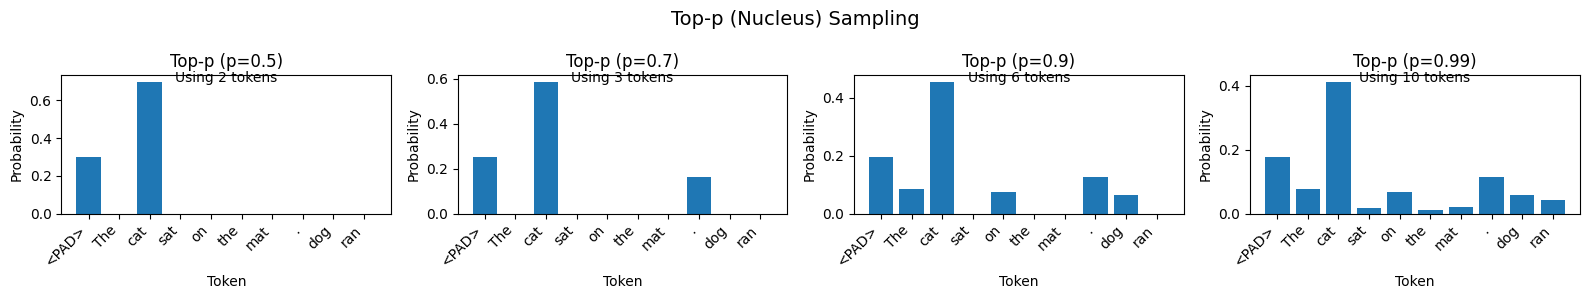

Top-p 장점:
- 동적 선택: 확률 분포에 따라 k가 자동 조절
- 더 자연스러운 샘플링


In [36]:
def top_p_sampling(logits, p=0.9, temperature=1.0):
    """누적 확률 p까지의 토큰만 사용"""
    # Temperature & softmax
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    
    # 확률 내림차순 정렬
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    # p를 넘는 지점 찾기
    cutoff_idx = torch.where(cumulative_probs > p)[0]
    if len(cutoff_idx) > 0:
        cutoff_idx = cutoff_idx[0].item()
    else:
        cutoff_idx = len(sorted_probs) - 1
    
    # 필터링
    filtered_logits = torch.full_like(logits, float('-inf'))
    selected_indices = sorted_indices[:cutoff_idx + 1]
    filtered_logits[selected_indices] = logits[selected_indices]
    
    # 재정규화 & 샘플링
    final_probs = F.softmax(filtered_logits, dim=-1)
    next_token = torch.multinomial(final_probs, 1).item()
    
    return next_token, final_probs, cutoff_idx + 1

# Top-p 효과 시각화
p_values = [0.5, 0.7, 0.9, 0.99]
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for i, p in enumerate(p_values):
    _, probs, num_tokens = top_p_sampling(logits.clone(), p=p)
    
    axes[i].bar(range(vocab_size), probs.numpy())
    axes[i].set_title(f'Top-p (p={p})')
    axes[i].set_xlabel('Token')
    axes[i].set_ylabel('Probability')
    axes[i].set_xticks(range(vocab_size))
    axes[i].set_xticklabels(vocab, rotation=45, ha='right')
    axes[i].text(0.5, 0.95, f'Using {num_tokens} tokens', 
                transform=axes[i].transAxes, ha='center')

plt.suptitle('Top-p (Nucleus) Sampling', fontsize=14)
plt.tight_layout()
plt.show()

print("Top-p 장점:")
print("- 동적 선택: 확률 분포에 따라 k가 자동 조절")
print("- 더 자연스러운 샘플링")

## 7. 전체 생성 파이프라인

In [54]:
@torch.no_grad()
def generate(start_tokens, max_new_tokens=10, 
             temperature=1.0, top_k=None, top_p=None):
    """
    완전한 텍스트 생성 함수
    """
    context = start_tokens.copy()
    
    for _ in range(max_new_tokens):
        # 모델 예측 (가상)
        logits = mock_gpt_prediction(context)
        
        # Temperature 적용
        logits = logits / temperature
        
        # Top-k 필터링
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[-1]] = float('-inf')
        
        # Top-p 필터링
        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(
                F.softmax(sorted_logits, dim=-1), dim=-1
            )
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[0] = False  # 최소 1개는 유지
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[indices_to_remove] = float('-inf')
        
        # 확률 계산 & 샘플링
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()
        
        context.append(next_token)
        
        # 종료 조건 (예: 마침표)
        if next_token == stoi['.']:
            break
    
    return context

# 다양한 설정으로 생성
settings = [
    {"name": "Greedy", "temp": 0.01, "top_k": 1},
    {"name": "Conservative", "temp": 0.7, "top_k": 5},
    {"name": "Balanced", "temp": 1.0, "top_p": 0.9},
    {"name": "Creative", "temp": 1.3, "top_p": 0.95},
]

print("다양한 생성 전략:\n")
for setting in settings:
    print(f"{setting['name']:15}:", end=" ")
    
    tokens = generate(
        [stoi['The']], 
        max_new_tokens=6,
        temperature=setting.get('temp', 1.0),
        top_k=setting.get('top_k'),
        top_p=setting.get('top_p')
    )
    
    text = ' '.join([itos[t] for t in tokens])
    print(text)

다양한 생성 전략:

Greedy         : The cat sat on cat sat on
Conservative   : The dog ran ran .
Balanced       : The dog ran sat on ran on
Creative       : The the <PAD> sat on dog sat


## 8. Repetition Penalty

반복을 줄이기 위한 페널티

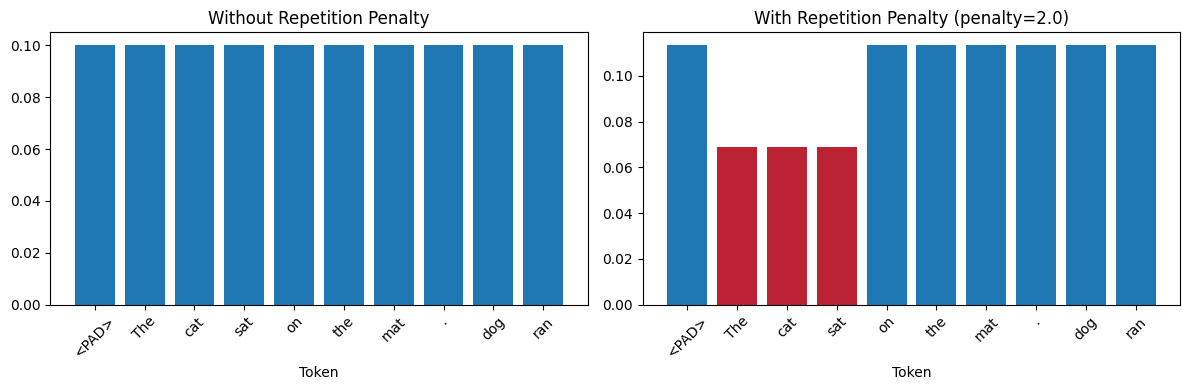

빨간색 막대 = 이미 생성된 토큰 (페널티 적용)
→ 반복 확률 감소


In [55]:
def apply_repetition_penalty(logits, generated_tokens, penalty=1.2):
    """이미 생성된 토큰에 페널티 적용"""
    for token in set(generated_tokens):
        # 이미 나온 토큰의 logit을 감소
        logits[token] = logits[token] / penalty
    return logits

# 반복 페널티 효과 시연
context = [stoi['The'], stoi['cat'], stoi['sat']]
logits = torch.tensor([1.0] * vocab_size)  # 균등한 logits

# 페널티 없음
probs_no_penalty = F.softmax(logits, dim=-1)

# 페널티 적용
logits_with_penalty = apply_repetition_penalty(logits.clone(), context, penalty=2.0)
probs_with_penalty = F.softmax(logits_with_penalty, dim=-1)

# 비교 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(vocab_size), probs_no_penalty.numpy())
ax1.set_title('Without Repetition Penalty')
ax1.set_xlabel('Token')
ax1.set_xticks(range(vocab_size))
ax1.set_xticklabels(vocab, rotation=45)

ax2.bar(range(vocab_size), probs_with_penalty.numpy())
ax2.set_title('With Repetition Penalty (penalty=2.0)')
ax2.set_xlabel('Token')
ax2.set_xticks(range(vocab_size))
ax2.set_xticklabels(vocab, rotation=45)

# 이미 나온 토큰 표시
for idx in context:
    ax2.bar(idx, probs_with_penalty[idx].numpy(), color='red', alpha=0.7)

plt.tight_layout()
plt.show()

print("빨간색 막대 = 이미 생성된 토큰 (페널티 적용)")
print("→ 반복 확률 감소")

## 💡 핵심 인사이트

1. **Autoregressive = 순차적 생성**
   - 한 번에 한 토큰
   - 이전 출력이 다음 입력

2. **Temperature = 창의성 조절**
   - Low: 안전하고 예측 가능
   - High: 창의적이고 다양함

3. **Top-k/Top-p = 품질 보장**
   - 낮은 확률 토큰 제거
   - 무의미한 출력 방지

4. **Trade-offs**
   - Quality vs Diversity
   - Safety vs Creativity
   - Speed vs Accuracy

## 🎯 실전 팁

### 용도별 추천 설정

**코드 생성**
```python
temperature=0.2, top_k=10
# 정확성 중요, 창의성 불필요
```

**창작 글쓰기**
```python
temperature=1.0, top_p=0.9
# 다양성과 창의성 중요
```

**대화/챗봇**
```python
temperature=0.7, top_k=40
# 균형잡힌 응답
```

**요약/번역**
```python
temperature=0.3, top_k=5
# 정확성과 일관성 중요
```